# **Статистический анализ рыночных и новостных данных**

[1. Анализ рыночных данных](#market_data)<br>
[2. Анализ новостных данных](#news_data)

In [1]:
import os
print(os.listdir("../input"))

['marketdata_sample.csv', 'news_sample.csv']


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import seaborn as sb

from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import datetime
import gc

# import environment for data
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


## Анализ рыночных данных
<a name="market_data"></a>

Загрузка рыночных данных в dataframe market_df

In [3]:
(market_df, _) = env.get_training_data()
print("market_data shape:", market_df.shape)

market_data shape: (4072956, 16)


In [4]:
market_df.head()

time   ...    universe
0 2007-02-01 22:00:00+00:00   ...         1.0
1 2007-02-01 22:00:00+00:00   ...         0.0
2 2007-02-01 22:00:00+00:00   ...         1.0
3 2007-02-01 22:00:00+00:00   ...         1.0
4 2007-02-01 22:00:00+00:00   ...         1.0

[5 rows x 16 columns]

В данных есть пропуски, причем, возможно, только в 4-х столбцах. Посмотрим более детально

In [5]:
print("Count of Nan values")
for column in market_df:
    t = market_df.shape[0] - market_df[column].count(level=None)
    print(column + ": ", t)

Count of Nan values
time:  0
assetCode:  0
assetName:  0
volume:  0
close:  0
open:  0
returnsClosePrevRaw1:  0
returnsOpenPrevRaw1:  0
returnsClosePrevMktres1:  15980
returnsOpenPrevMktres1:  15988
returnsClosePrevRaw10:  0
returnsOpenPrevRaw10:  0
returnsClosePrevMktres10:  93010
returnsOpenPrevMktres10:  93054
returnsOpenNextMktres10:  0
universe:  0


Предположение подтвердилось, при этом пропущенных данных не так много (максимум 93_054 из 4_072_956). В дальнейшем их нужно будет удалить из рассморения или заполнить значениями "по умолчанию".

Генерация признаков

In [6]:
#Добавим новые признаки для исследования
def prepare_market_data(market_data):
    market_data['volume_to_mean'] = round(market_data['volume'] / market_data['volume'].mean(), 4)
    market_data['returnsOpenPrevRaw1_to_volume'] = round(market_data['returnsOpenPrevRaw1'] / market_data['volume'],4)
    market_data['day_price_diff'] = round(market_data['close'] - market_data['open'],4)
    market_data['day_close_to_open'] =  round(market_data['close'] / market_data['open'], 4)
    return market_data

market_df = prepare_market_data(market_df)

In [7]:
#Функции для построения диаграммы рассеяния данных, сгрупированных по времени

def add_to_scatter(data, df_for_add, added_column = 'mean', name = '', mode='lines'):
    data.append(go.Scatter(
        x = df_for_add['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df_for_add[added_column].values,
        name = name,
        mode = mode
    ))
    return data

def set_layout(title, yaxis='Price (USD)'):
    return go.Layout(dict(title = title,
                  xaxis = dict(title = ''),
                  yaxis = dict(title = ''),
                  ),legend=dict(
                orientation="h"))

def show_by_aggfunc(grouped_df, col, func, title, mode='lines'):
    data = []
    price_df = grouped_df[col].agg([func]).reset_index()
    add_to_scatter(data=data, df_for_add=price_df, added_column = func, mode = mode)
    py.iplot(dict(data=data, layout=set_layout(title)), filename='basic-line')
    
def show_by_quantiles(grouped_df, col, quantiles, title):
    data = []
    for i in quantiles:
        price_df = grouped_df[col].quantile(i).reset_index()
        add_to_scatter(data=data, df_for_add=price_df, name = f'{i} quantile', added_column = col)
    py.iplot(dict(data=data, layout=set_layout(title)), filename='basic-line')
    
#создание признака "год"
def time_to_year(df):
    df['year'] = df['time'].map(lambda x: x.date().year)
    return df

In [8]:
grouped_by_time = market_df.groupby('time')

#### Рассмотрим распределение цен на момент закрытия торгов у 10 случайных активов

In [11]:
data = []
for asset in np.random.choice(market_df['assetName'].unique(), 10):
    asset_df = market_df[(market_df['assetName'] == asset)]
    add_to_scatter(data=data, df_for_add=asset_df, added_column='close', name=asset)

py.iplot(dict(data=data, layout=set_layout("Цены 10 случайных активов на момент закрытия торгов")), filename='basic-line')

Из диаграммы видно, что некоторые активы присутствуют не на всем промежутке от 2007 до 2016 года.<br><br>
### Перейдем к более детальному изучению всей выборки

In [12]:
show_by_aggfunc(grouped_by_time, 'close', 'mean', 'Тренды цен при закрытии торгов (mean)')

Очевидно, что в 2008 году произошло серьезное падение цен, в этот промежуток времени данные могут быть зашумлены.<br>
Посмотрим, как ведут себя квантили

In [13]:
quantiles = [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98]
show_by_quantiles(grouped_by_time, 'close', quantiles, 'Тренды цен при закрытии торгов (квантили)')

<p>Из графика видно, что с течением времени цены, соответсвующие высоким квантилям (от 0.9), растут значительно быстрее, чем остлальные. При этом разница цен, соответствующих квантилям 0.98 и 0.95 с течением времени значительно увеличивается (относительно, например, разницы цен, соответсвующих квантилям 0.95 и 0.9). Таким образом можно заключить, что с течением времени выделяется группа самых "дорогих" активов.</p>
<p>
Кроме того, можно заметить, что промежутки снижения цен (назовем их кризисами) наиболее сильно отражаются на "дорогих" активах и практически не отражаются на "дешевых". Вероятно, в момент кризиса показатель цены может оказаться важным.</p>

### Посмотрим на аналогичные графики в момент открытия торгов

In [14]:
show_by_aggfunc(grouped_by_time, 'open', 'mean', 'Тренды цен при открытии торгов (mean)')

В большинстве временных промежутков график выглядит аналогично, однако в конце 2009 - начале 2010 года на протяжении нескольких дней происходил очень резкий скачок цен при открытии вверх, что не отражается на графике тренда цен при закрытии торгов. Необходимо дальнейшее исследование

In [15]:
quantiles = [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98]
show_by_quantiles(grouped_by_time, 'open', quantiles, 'Тренды цен при открытии торгов (квантили)')

График квантилей не изменился. Посмотрим на график изменения цен

In [16]:
show_by_aggfunc(grouped_by_time, 'day_price_diff', 'mean', 'Тренды изменения цен за 1 день (mean)')

В промежутке с 30 декабря 2009 по 5 января 2010 наблюдается сильное среднее суточное падение цен.<br>
Кроме того, аналогичная ситуация наблюдается 29 сентября 2008 года.<br>
Интересно будет провести исследования тональности новостей за эти промежутки времени.

In [17]:
print(f"Среднее изменение цен в течение дня составляет {grouped_by_time['day_price_diff'].mean().mean():.4f}.")

Среднее изменение цен в течение дня составляет -0.0008.


###  Динамика изменения цен на временных интервалах

In [18]:
grouped_by_year = time_to_year(market_df).groupby('year')

In [19]:
grouped_by_year.groups.keys()

dict_keys([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [20]:
for year in range(2007, 2017):
    print(f"Среднее изменение цен в течение дня составляет в {year} году {grouped_by_year.get_group(year)['day_price_diff'].mean():.4f}.")

Среднее изменение цен в течение дня составляет в 2007 году -0.0159.
Среднее изменение цен в течение дня составляет в 2008 году -0.0501.
Среднее изменение цен в течение дня составляет в 2009 году 0.0278.
Среднее изменение цен в течение дня составляет в 2010 году -0.0105.
Среднее изменение цен в течение дня составляет в 2011 году -0.0108.
Среднее изменение цен в течение дня составляет в 2012 году 0.0158.
Среднее изменение цен в течение дня составляет в 2013 году 0.0253.
Среднее изменение цен в течение дня составляет в 2014 году -0.0073.
Среднее изменение цен в течение дня составляет в 2015 году -0.0052.
Среднее изменение цен в течение дня составляет в 2016 году 0.0238.


Наибольшее среднесуточное падение цен соответсвует 2008 году.

### Исследуем дисперсию

In [21]:
show_by_aggfunc(grouped_by_time, 'day_price_diff', 'std', 'Тренды изменения цен за 1 день (standart deviation)')

Как и следовало ожидать, в 2008 и начале 2010 годов есть скачки. Любопытно, что, в целом, отклонения небольшие

In [22]:
print(f"Среднее изменение цен в течение дня составляет {grouped_by_time['day_price_diff'].std().mean():.4f}.")

Среднее изменение цен в течение дня составляет 1.0335.


Это значение зашумлено выбросом в 2010 году

In [23]:
for year in range(2007, 2017):
    print(f"Среднее изменение цен в течение дня составляет в {year} году {grouped_by_year.get_group(year)['day_price_diff'].std():.4f}.")

Среднее изменение цен в течение дня составляет в 2007 году 1.9117.
Среднее изменение цен в течение дня составляет в 2008 году 5.8139.
Среднее изменение цен в течение дня составляет в 2009 году 0.7955.
Среднее изменение цен в течение дня составляет в 2010 году 15.9193.
Среднее изменение цен в течение дня составляет в 2011 году 0.8916.
Среднее изменение цен в течение дня составляет в 2012 году 0.7814.
Среднее изменение цен в течение дня составляет в 2013 году 0.8408.
Среднее изменение цен в течение дня составляет в 2014 году 1.0927.
Среднее изменение цен в течение дня составляет в 2015 году 1.1702.
Среднее изменение цен в течение дня составляет в 2016 году 1.1627.


#### Посмотрим, на среднюю дисперсию разницы цен в 2010 году после 6 января

In [24]:
gr_2010 = grouped_by_year.get_group(2010).reset_index()
gr_2010['date'] = gr_2010['time'].map(lambda x: datetime.date(x.year,x.month,x.day))
first_ind = np.where(gr_2010.date > datetime.date(2010, 1, 5))[0][0]

In [25]:
print(f"Среднее изменение цен в течение дня составляет в 2010 году после 05.01 {gr_2010[first_ind + 1:]['day_price_diff'].std():.4f}.")

Среднее изменение цен в течение дня составляет в 2010 году после 05.01 0.7174.


Не считая скачка, в промежуток с 2009 по 2013 года средняя дисперсия очень мала. Таким образом, эти данные менее всего зашумлены

#### Посмотрим на то, насколько большими в количесвенном отношении были падения цен

In [26]:
show_by_aggfunc(grouped_by_time, 'day_price_diff', 'min', 'Тренды изменения цен за 1 день (min)')

Выясняется, что падение в начале 2010 года очень сильное. Необходимо анализировать новости в эти дни

In [27]:
show_by_aggfunc(grouped_by_time, 'day_price_diff', 'max', 'Тренды изменения цен за 1 день (max)')

Подъем цен не такой большой. На графике виден скачок в 2016 году

### Перейдем к изучению целевого признака

In [28]:
show_by_aggfunc(grouped_by_time, 'returnsOpenNextMktres10', 'mean', 'Тренд returnsOpenNextMktres10 (mean)')

Интересно, что в 2007 году признак нестабилен. Возможно, это шум, который нужно будет убрать

In [29]:
quantiles = [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98]
show_by_quantiles(grouped_by_time, 'returnsOpenNextMktres10', quantiles, 'Тренд returnsOpenNextMktres10 (quantiles)')

In [30]:
show_by_aggfunc(grouped_by_time, 'returnsOpenNextMktres10', 'std', 'Тренд returnsOpenNextMktres10 (standart deviation)')

И еще раз убеждаемся, что в 2007 году много шума. Резкие скачки 2008 года соответсвуют кризису. Скорее всего этот промежуток стоит оставить

### Корреляция

In [31]:
#Функция для изображения корреляции
def show_heatmap_cor(df):
    C_mat = df.corr()
    fig = plt.figure(figsize=(15,15))
    sb.heatmap(C_mat,vmax=0.5,square=True,annot=True)
    plt.show()

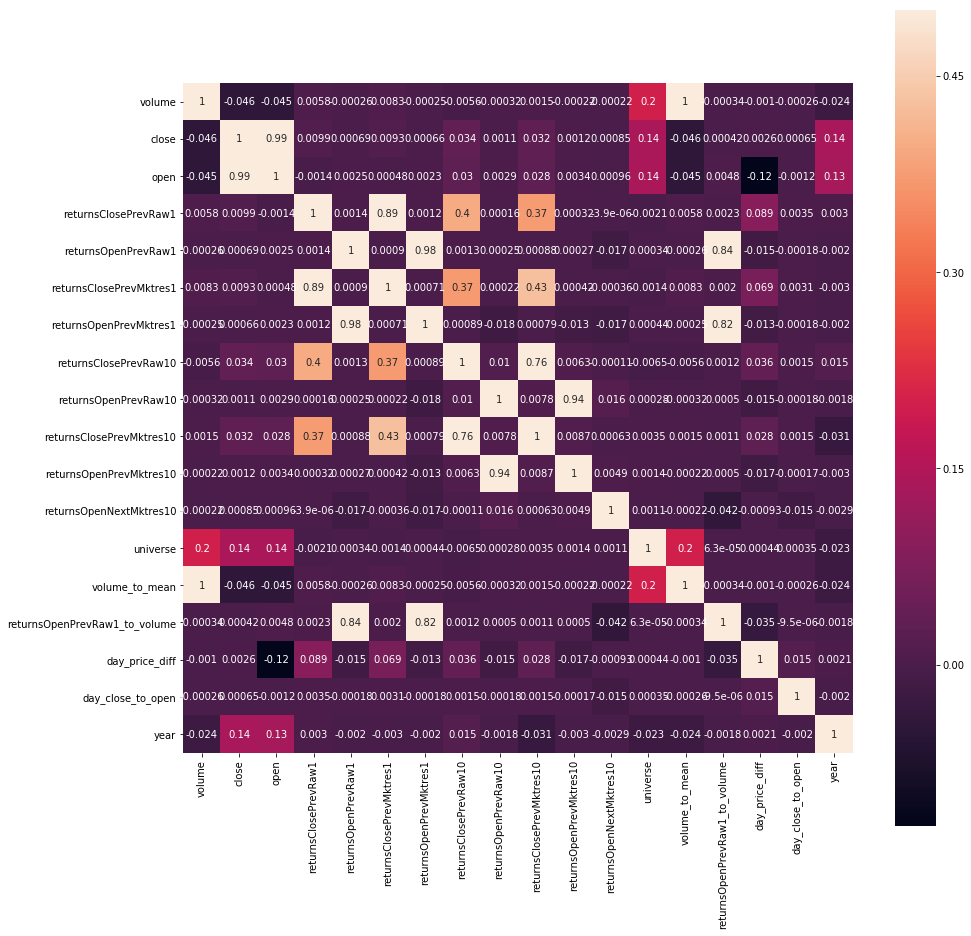

In [32]:
show_heatmap_cor(market_df)

Из диаграммы видно, что признаки слабо коррелируют с целевым и, в целом, друг с другом. Однако есть и избыточные признаки, например, volume_to_mean

Найдем корелляции после удаления выбросов (сглаживание по всему временному промежутку)

In [33]:
#Удаление выбросов
def remove_outlier(df,column_list,lower_percentile,upper_percentile):
    for col in column_list:
        df = df.dropna()
        df = (df[(df[col]<np.quantile(df[col],upper_percentile, axis=0)) & (df[col]>np.quantile(df[col],lower_percentile, axis=0))])
    return df
outlier_removal_list = ['returnsClosePrevRaw1',
                        'returnsOpenPrevRaw1',
                        'returnsClosePrevMktres1',
                        'returnsOpenPrevMktres1',
                        'returnsClosePrevRaw10',
                        'returnsOpenPrevRaw10',
                        'returnsClosePrevMktres10',
                        'returnsOpenPrevMktres10',
                        'returnsOpenNextMktres10',
                       'day_price_diff']

Число данных уменьшилость с  4072956  до  3251177


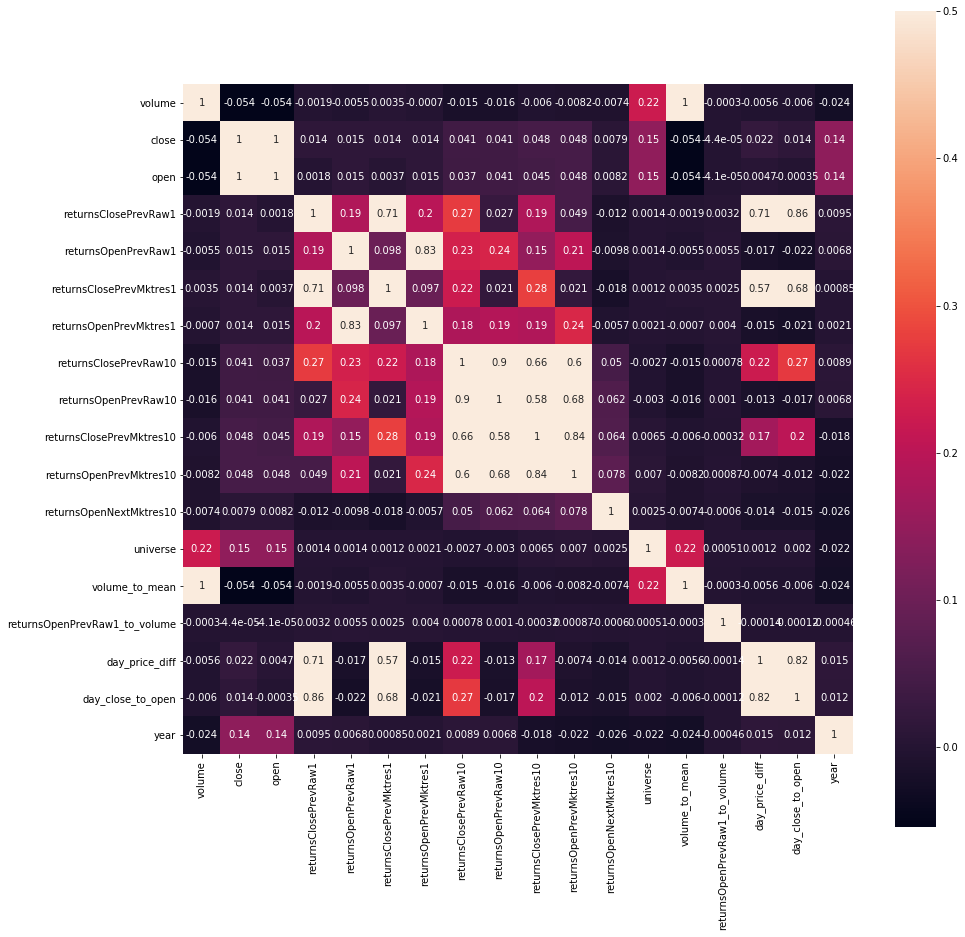

In [34]:
market_data_no_outlier = remove_outlier(market_df,outlier_removal_list, 0.01, 0.99)
print("Число данных уменьшилость с ",len(market_df['returnsOpenNextMktres10']),
      " до ",len(market_data_no_outlier['returnsOpenNextMktres10']))

show_heatmap_cor(market_data_no_outlier)

Видно, что признаки стали лучше коррелировать

Удалим данные за 2007 год, чтобы убрать выбросы только целевой переменной

In [35]:
market_date_by_time = market_df['time'].map(lambda x: datetime.date(x.year,x.month,x.day))
first_ind = np.where(market_date_by_time >= datetime.date(2008, 1, 1))[0][0]

In [36]:
market_df_since2008 = market_df[first_ind:]

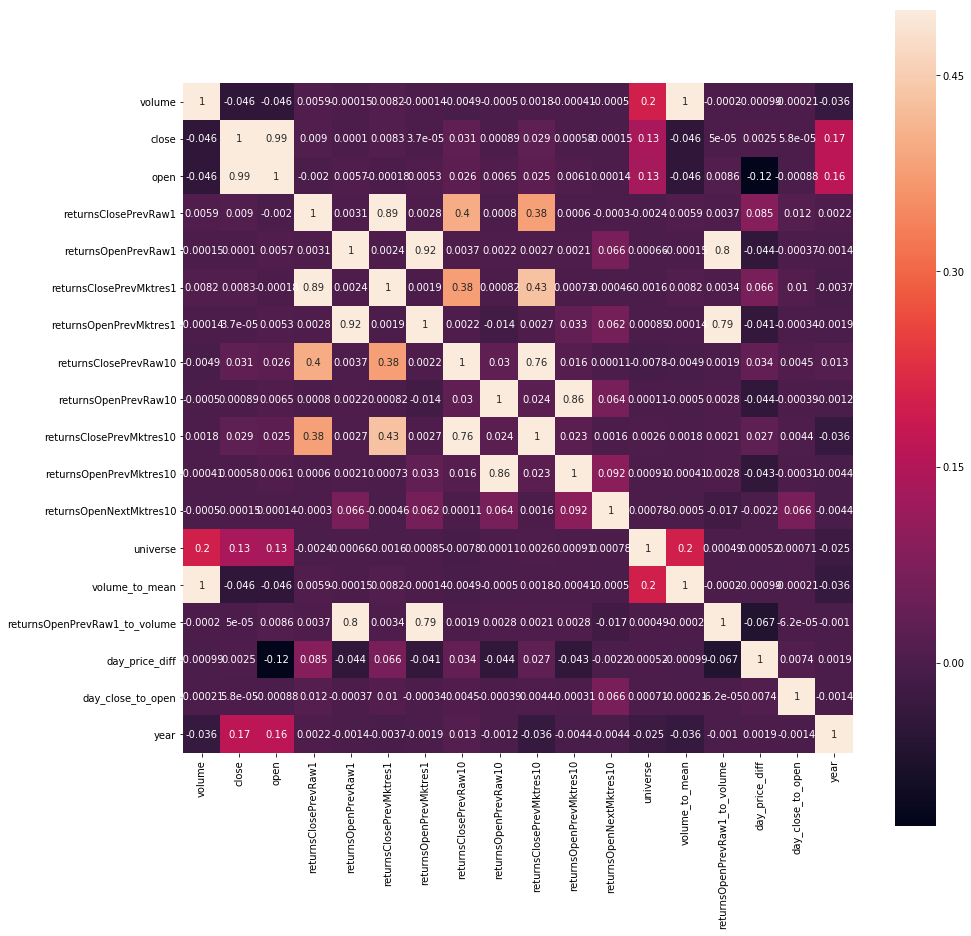

In [37]:
show_heatmap_cor(market_df_since2008)

По сравнению с изначальными данными корелляция целевого признака с остальными увеличилась.<br>
Теперь сгладим выбросы в остальных данных

Число данных уменьшилость с  4072956  до  2991523


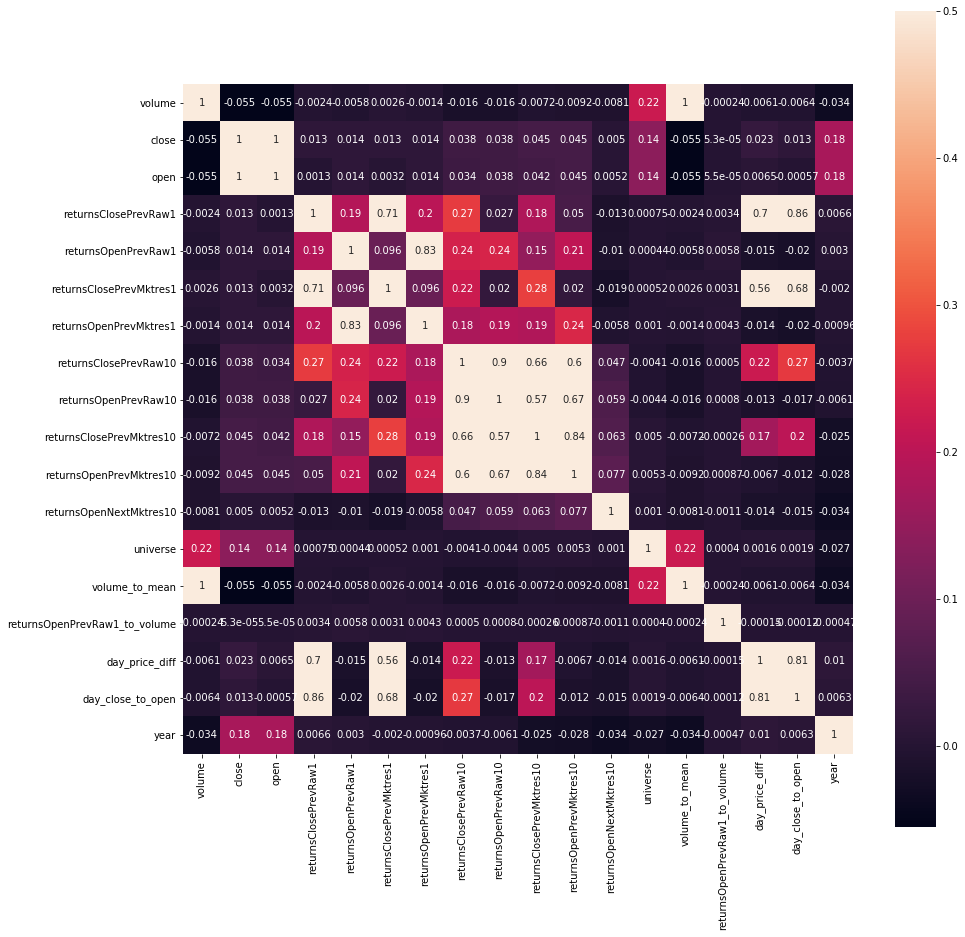

In [38]:
market_data_no_outlier = remove_outlier(market_df_since2008,outlier_removal_list, 0.01, 0.99)
print("Число данных уменьшилость с ",len(market_df['returnsOpenNextMktres10']),
      " до ",len(market_data_no_outlier['returnsOpenNextMktres10']))

show_heatmap_cor(market_data_no_outlier)

Видно, что корреляции почти не изменились. Значит, 2007 год можно удалить из рассмотрения без потери полноты

In [39]:
#Освобождение памяти
del market_df

## Анализ новостных данных
<a name="news_data"></a>

Загрузка новостных данных в dataframe news_df

In [40]:
(_, news_df) = env.get_training_data()
print("news_data shape:", news_df.shape)

news_data shape: (9328827, 35)


In [41]:
news_df.head()

time      ...       volumeCounts7D
0 2007-01-01 04:29:32+00:00      ...                    7
1 2007-01-01 07:03:35+00:00      ...                    3
2 2007-01-01 11:29:56+00:00      ...                   17
3 2007-01-01 12:08:37+00:00      ...                   15
4 2007-01-01 12:08:37+00:00      ...                    0

[5 rows x 35 columns]

Проанализируем, есть ли пропуски в данных

In [42]:
print("Count of Nan values")
for column in news_df:
    t = news_df.shape[0] - news_df[column].count(level=None)
    print(column + ": ", t)

Count of Nan values
time:  0
sourceTimestamp:  0
firstCreated:  0
sourceId:  0
headline:  0
urgency:  0
takeSequence:  0
provider:  0
subjects:  0
audiences:  0
bodySize:  0
companyCount:  0
headlineTag:  0
marketCommentary:  0
sentenceCount:  0
wordCount:  0
assetCodes:  0
assetName:  0
firstMentionSentence:  0
relevance:  0
sentimentClass:  0
sentimentNegative:  0
sentimentNeutral:  0
sentimentPositive:  0
sentimentWordCount:  0
noveltyCount12H:  0
noveltyCount24H:  0
noveltyCount3D:  0
noveltyCount5D:  0
noveltyCount7D:  0
volumeCounts12H:  0
volumeCounts24H:  0
volumeCounts3D:  0
volumeCounts5D:  0
volumeCounts7D:  0


Пропусков в данных нет

Генерация признаков

In [43]:
def prepare_news_data(news_data):
    news_data['headline_length'] = news_data['headline'].apply(lambda x: len(x))
    news_data['position'] = round(news_data['firstMentionSentence'] / news_data['sentenceCount'], 4)
    news_data['coverage'] = round(news_data['sentimentWordCount'] / news_data['wordCount'], 4) #доля новостей, в которых обсуждается актив
    news_data['word_in_sentence_count'] =  round(news_data['wordCount'] / news_data['sentenceCount'], 4)
    return news_data

news_df = prepare_news_data(news_df)

### Анализ тональности новостей

По каждому из видов тональности выведем топ 5 компаний

In [44]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_df.loc[news_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('--------------')
    print(f'In total: {df_sentiment.count()}')
    print('')

Top mentioned companies for negative sentiment are:
Citigroup Inc              30823
JPMorgan Chase & Co        29129
Bank of America Corp       28197
Apple Inc                  26702
Goldman Sachs Group Inc    25044
Name: assetName, dtype: int64
--------------
In total: 2813028

Top mentioned companies for neutral sentiment are:
Barclays PLC         24898
HSBC Holdings PLC    23191
Deutsche Bank AG     20702
BHP Billiton PLC     18019
Rio Tinto PLC        16782
Name: assetName, dtype: int64
--------------
In total: 2899131

Top mentioned companies for positive sentiment are:
Barclays PLC             22855
Apple Inc                22770
General Electric Co      20055
Royal Dutch Shell PLC    18206
Citigroup Inc            18025
Name: assetName, dtype: int64
--------------
In total: 3616668



Видно, что про одни и те же компании разные новости могут иметь разную тональность. <br>
Кроме того, большая часть новостей имеет негативную тональность.

In [45]:
grouped_news_by_sentiment = news_df.groupby('time')

Рассмотрим тональность в промежутке от 25.12.2009 до 10.01.2010 

In [46]:
news_date = news_df['time'].map(lambda x: datetime.date(x.year,x.month,x.day))

In [47]:
first_ind = np.where(news_date > datetime.date(2009, 12, 24))[0][0]
last_ind = np.where(news_date > datetime.date(2010, 1, 10))[0][0]

In [48]:
analysed_time_news = news_df[first_ind:last_ind]
show_by_aggfunc(analysed_time_news.groupby('time'), 'sentimentClass', 'mean', 'Тренд тональности новостей с 25.12.2009 по 10.01.2010 (mean)', mode='markers')

Снова какой-то определенной зависимости между тональностью новостей и причиной такого необычного поведения цен при открытии не прослеживается. Вероятно, стоит считать показатели цен в эти дни выбросами и удалить их при построении модели.

Теперь рассмотрим временной промежуток, соответсвующий "кризису"

In [49]:
first_ind = np.where(news_date > datetime.date(2008, 4, 1))[0][0]
last_ind = np.where(news_date > datetime.date(2009, 1, 1))[0][0]
df_sentiment = news_df['sentimentClass'][first_ind:last_ind]

In [50]:
sent_types = ['negative', 'neutral', 'positive']
list_sentiment_count = df_sentiment.value_counts()
for i in range(len(list_sentiment_count)):
    print(f"{sent_types[i]}: {list_sentiment_count[i-1]}")

negative: 213693
neutral: 210021
positive: 207277


Видно, что в рассматриваемом промежутке преобладают новости с негативной тональностью, но преобладание незначительное. Необходимо анализировать другие признаки

### Анализ других признаков

1. Urgency

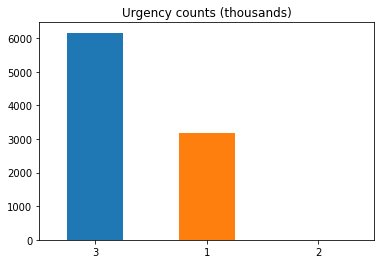

In [51]:
(news_df['urgency'].value_counts() / 1000).plot('bar')
plt.xticks(rotation=0)
plt.title('Urgency counts (thousands)');

Из диаграммы следует вывод, что среди новостей статей в 2 раза больше, чем оповещений

2. Количество слов в предложении

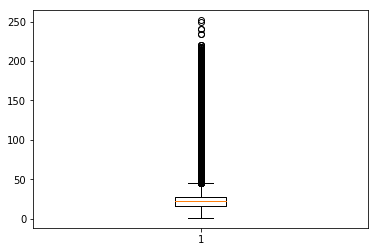

In [52]:
plt.boxplot(news_df['word_in_sentence_count']);

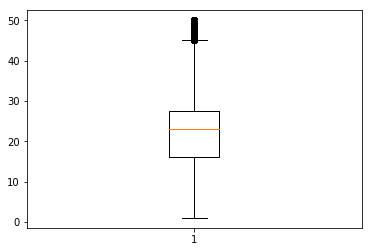

In [53]:
plt.boxplot(news_df['word_in_sentence_count'][news_df['word_in_sentence_count'] < 50]);

Значит, значения данного признака сосредоточены в диапазоне от 12 до 28. Причем очень возможно, что у них есть выбросы.

In [54]:
cnt_outiers_by_len = len(news_df['word_in_sentence_count'][news_df['word_in_sentence_count'] > 48])
print(f'выбросы (от 48): {cnt_outiers_by_len} ({cnt_outiers_by_len/news_df.shape[0]*100}%)')

выбросы (от 48): 169648 (1.8185351706061221%)


In [55]:
cnt_outiers_by_len = len(news_df['word_in_sentence_count'][news_df['word_in_sentence_count'] > 100])
print(f'огромные выбросы (от 100): {cnt_outiers_by_len} ({cnt_outiers_by_len/news_df.shape[0]*100}%)')

огромные выбросы (от 100): 8571 (0.09187650280147762%)


Рассмотрим, в каком промежутке сосредоточены эти выбросы

In [56]:
outiers_by_len = news_df[news_df['word_in_sentence_count'] > 100]
show_by_aggfunc(outiers_by_len.groupby('time'), 'word_in_sentence_count', 'mean', 'Тренд количества слов в предложении (mean)')

Из диаграммы можно сделать следующие выводы:
* В промежуток с 2009 года по 2012 год (если не считать выброс в конце 2009 года) публиковалось меньше всего новостей с большим рассматриваемым показателем; <br>
* В момент кризиса 2008 года была самая большая плотность выбросов данного показателя. Совпадение?
* Выброс в конце 2009 года может быть связан с необычным поведением цен на рынке с 30.12.2009 по 5.01.2010

### Новостные теги

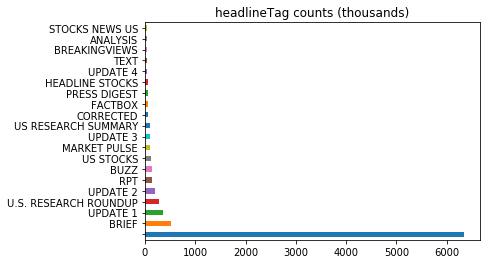

In [57]:
(news_df['headlineTag'].value_counts() / 1000)[:20].plot('barh');
plt.title('headlineTag counts (thousands)');

Есть теги, которые встречаются чаще других. Большая часть новостей не имеет тегов

### AssetName

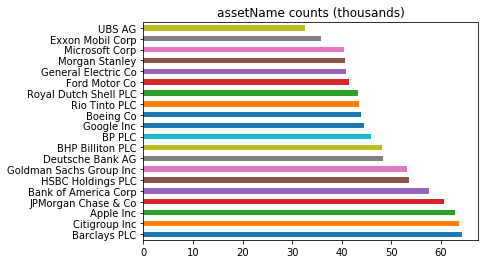

In [58]:
grouped_assetName = news_df['assetName'].value_counts() / 1000
grouped_assetName[:20].plot('barh');
plt.title('assetName counts (thousands)');

In [59]:
print (f'количество assetName: {grouped_assetName.shape[0]}')

количество assetName: 9777


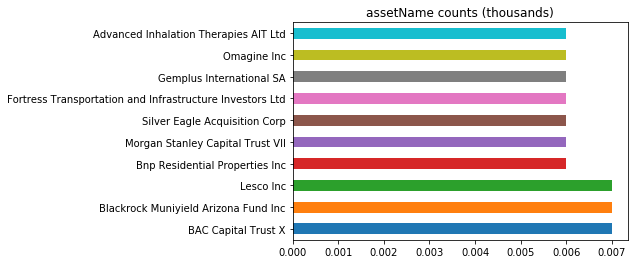

In [60]:
grouped_assetName[8700:8710].plot('barh');
plt.title('assetName counts (thousands)');

Из диаграмм следует, что в данных есть как компании, активы которых упоминаются часто, так и компании с редко упоминаемыми активами.

## Предварительные выводы

1. В 4-х столбцах рыночных данных есть пропуски. При обучении их необходимо будет удалить, либо заполнить некоторыми значениями;<br>
2. Данные о некоторых активах представлены на крайне малых временных промежутках;
3. В 2008 году на рынке наблюдалось общее снижение цен (возможно, связанное с кризисом), при этом:
    * Явной зависимости между падением цен и тональностью новостей не наблюдается;
    * Возможно сущестование зависимости между падением цен и средним количеством слов в заголовках новостей, а также количеством предложений в заголовке;
4. Целевая переменная сильно зашумлена до 2008 года, поэтому данные за 2007 год стоит исключить при обучении модели;
5. Признаки слабо коррелируют, однако при удалении шумов из некоторых приводит к увеличению корреляции с целевой переменной.